- 가중치 설정 X
- 학습스케줄러 X 
- 예측 X
- 체크포인트 X
- 모델 저장 X

In [586]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torchinfo import summary
import torchvision.models as models

이미지 전처리 및 dataset 생성

In [587]:
preprocessing = transforms.Compose([
    transforms.Resize(size = (150, 150)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [588]:
file_dir = './image'
imgDS = ImageFolder(root = file_dir, transform = preprocessing)

In [589]:
print(imgDS.classes, imgDS.class_to_idx)

['chicken', 'poodle'] {'chicken': 0, 'poodle': 1}


In [590]:
imgDS.imgs[:5]

[('./image\\chicken\\soy_chicken (1).jpg', 0),
 ('./image\\chicken\\soy_chicken (100).jpg', 0),
 ('./image\\chicken\\soy_chicken (101).jpg', 0),
 ('./image\\chicken\\soy_chicken (102).jpg', 0),
 ('./image\\chicken\\soy_chicken (103).jpg', 0)]

In [591]:
print(type(imgDS))

<class 'torchvision.datasets.folder.ImageFolder'>


In [592]:
len(imgDS)

390

In [593]:
count = 1
for img, label in imgDS:
    # print(label)
    if label == 1:
        break
    count += 1
print(count)
# chicken : 0 (200)   poodle :  (190)

200


In [594]:
# dataset에서 train, valid, test를 나누어보자
seed_gen = torch.Generator().manual_seed(42)
tr, val, ts = 0.7,0.1,0.2
trainDS, validDS, testDS = random_split(imgDS, [tr, val, ts], generator=seed_gen)
print(len(trainDS), len(validDS), len(testDS))

273 39 78


dataloader 생성

In [595]:
# 각 분류별로 dataloader를 생성해보자
batch_size = 10
train_dl = DataLoader(trainDS, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(validDS, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(testDS, batch_size = batch_size, shuffle=True)
print(len(train_dl), len(valid_dl), len(test_dl))

28 4 8


In [596]:
# chicken_dl = DataLoader(dataset = imgDS)
# for (image, label) in chicken_dl:
#         print(image.shape, label)

전이학습 기릿

In [597]:
# 모델 인스턴스 생성 : 사전 학습된 모델 로딩 
#  => 일단 기본으로! 가중치는 나중에 설정해보자
res_model = models.resnet18()

# 전결합층 변경
res_model.fc = nn.Linear(in_features = 512, out_features = 1)

In [598]:
res_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [599]:
# summary(res_model, input_size = (1, 3, 150, 150))

In [600]:
# 모델의 합성곱층 가중치 고정
for param in res_model.parameters(): 
    param.requires_grad = False
for param in res_model.fc.parameters():   # 완전 연결층은 학습
    param.requires_grad = True
    
optimizer = torch.optim.Adam(res_model.fc.parameters())
cost = torch.nn.BCELoss() # 손실함수 정의
print(res_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

학습, 검증, 테스트 함수 정의

In [601]:
import torchmetrics.functional as metrics

def training(dataloader):
    res_model.train()
    loss_list = []
    acc_list = []
    precision_list = []
    recall_list = []
    f1score_list = []
    for image, label in dataloader:
        # 학습
        pre_label = res_model(image)
        pre_label = F.sigmoid(pre_label)
        
        # 여기서 활성함수 나온것을 그대로 써도 될까? 아님 1과 0으로 바꿔야할까??
        
        pre_label = pre_label.squeeze()
        # print(label.shape, pre_label.shape)
        # print(label, pre_label, sep = '\n\n')
        
        # 손실계산
        train_loss = cost(pre_label, label.float())
        # train_loss = cost(pre_label, label)
        
        # w,b 업데이트
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        # 정확도
        acc = metrics.accuracy(pre_label, label, task = 'binary') 
        precision = metrics.precision(pre_label, label, task = 'binary')
        recall = metrics.recall(pre_label, label, task = 'binary')
        f1score = metrics.recall(pre_label, label, task = 'binary')
        loss_list.append(train_loss)
        acc_list.append(acc)
        precision_list.append(precision)
        recall_list.append(recall)
        f1score_list.append(f1score)
    total_loss = sum(loss_list) / len(loss_list)
    total_acc = sum(acc_list) / len(acc_list)
    total_precision = sum(precision_list) / len(precision_list)
    total_recall = sum(recall_list)/len(recall_list)
    total_f1score = sum(f1score_list) / len(f1score_list)
    # print(f"[TOTAL Train Loss] ==> {total_loss}")
    # print(f"ACC : {total_acc}  Precision : {total_precision}  Recall : {total_recall} F1score : {total_f1score}")
    return total_loss, total_acc, total_precision, total_recall, total_f1score

training(train_dl)

(tensor(0.6554, grad_fn=<DivBackward0>),
 tensor(0.5738),
 tensor(0.1869),
 tensor(0.1655),
 tensor(0.1655))

In [602]:
def valid_testing(dataloader):
    res_model.eval()
    loss_list = []
    acc_list = []
    precision_list = []
    recall_list = []
    f1score_list = []
    for image, label in dataloader:
        # 학습
        pre_label = res_model(image)
        pre_label = F.sigmoid(pre_label)

        pre_label = pre_label.squeeze()
        # print(label.shape, pre_label.shape)
        # print(label, pre_label, sep = '\n\n')
        
        # 손실계산
        valid_loss = cost(pre_label, label.float())
        # train_loss = cost(pre_label, label)
        
        # 정확도
        acc = metrics.accuracy(pre_label, label, task = 'binary') 
        precision = metrics.precision(pre_label, label, task = 'binary')
        recall = metrics.recall(pre_label, label, task = 'binary')
        f1score = metrics.recall(pre_label, label, task = 'binary')
        loss_list.append(valid_loss)
        acc_list.append(acc)
        precision_list.append(precision)
        recall_list.append(recall)
        f1score_list.append(f1score)
    total_loss = sum(loss_list) / len(loss_list)
    total_acc = sum(acc_list) / len(acc_list)
    total_precision = sum(precision_list) / len(precision_list)
    total_recall = sum(recall_list)/len(recall_list)
    total_f1score = sum(f1score_list) / len(f1score_list)
    # print(f"[TOTAL Train Loss] ==> {total_loss}")
    # print(f"ACC : {total_acc}  Precision : {total_precision}  Recall : {total_recall} F1score : {total_f1score}")
    return total_loss, total_acc, total_precision, total_recall, total_f1score

# valid_testing(valid_dl)

학습 진행해보자

In [603]:
epoch_num = 10
training_list = [[], [], [], [], []]
validing_list = [[], [], [], [], []]

In [604]:
# loss, acc, precision, recall, f1
for epo in range(epoch_num):
    # 학습
    loss, acc, prec, rec, f1 = training(train_dl)
    print(loss, acc, prec, rec, f1)
    training_list[0].append(loss.item())
    training_list[1].append(acc.item())
    training_list[2].append(prec.item())
    training_list[3].append(rec.item())
    training_list[4].append(f1.item())
    print(f"epo => {epo}  학습중")
    # 검증
    loss, acc, prec, rec, f1 = valid_testing(valid_dl)
    validing_list[0].append(loss.item())
    validing_list[1].append(acc.item())
    validing_list[2].append(prec.item())
    validing_list[3].append(rec.item())
    validing_list[4].append(f1.item())
    print(f"epo => {epo}  검증중")

tensor(0.5838, grad_fn=<DivBackward0>) tensor(0.7571) tensor(0.7955) tensor(0.7335) tensor(0.7335)
epo => 0  학습중
epo => 0  검증중
tensor(0.5451, grad_fn=<DivBackward0>) tensor(0.7631) tensor(0.7836) tensor(0.8019) tensor(0.8019)
epo => 1  학습중
epo => 1  검증중
tensor(0.5473, grad_fn=<DivBackward0>) tensor(0.7500) tensor(0.7782) tensor(0.7371) tensor(0.7371)
epo => 2  학습중
epo => 2  검증중
tensor(0.5187, grad_fn=<DivBackward0>) tensor(0.7750) tensor(0.8363) tensor(0.7323) tensor(0.7323)
epo => 3  학습중
epo => 3  검증중
tensor(0.4914, grad_fn=<DivBackward0>) tensor(0.7952) tensor(0.7952) tensor(0.7631) tensor(0.7631)
epo => 4  학습중
epo => 4  검증중
tensor(0.4805, grad_fn=<DivBackward0>) tensor(0.7893) tensor(0.7176) tensor(0.8170) tensor(0.8170)
epo => 5  학습중
epo => 5  검증중
tensor(0.4732, grad_fn=<DivBackward0>) tensor(0.7798) tensor(0.7401) tensor(0.7742) tensor(0.7742)
epo => 6  학습중
epo => 6  검증중
tensor(0.4827, grad_fn=<DivBackward0>) tensor(0.7905) tensor(0.8037) tensor(0.7507) tensor(0.7507)
epo => 7  학습

In [605]:
print(training_list, validing_list, sep = '\n\n')

[[0.583766758441925, 0.5450889468193054, 0.5472517609596252, 0.5187483429908752, 0.49140802025794983, 0.4804704487323761, 0.47317495942115784, 0.48273226618766785, 0.4661136567592621, 0.4629448354244232], [0.7571428418159485, 0.7630952000617981, 0.75, 0.7750000357627869, 0.7952380776405334, 0.7892856597900391, 0.7797619104385376, 0.7904761433601379, 0.7880951166152954, 0.7880951762199402], [0.7954931855201721, 0.7836309671401978, 0.7782313227653503, 0.836309552192688, 0.7951530814170837, 0.7176020741462708, 0.7400509119033813, 0.8036565184593201, 0.808588445186615, 0.7986394762992859], [0.7335034608840942, 0.8019132614135742, 0.7371174097061157, 0.7323129773139954, 0.7630952596664429, 0.8169642686843872, 0.7742347121238708, 0.7506803274154663, 0.7926870584487915, 0.7694726586341858], [0.7335034608840942, 0.8019132614135742, 0.7371174097061157, 0.7323129773139954, 0.7630952596664429, 0.8169642686843872, 0.7742347121238708, 0.7506803274154663, 0.7926870584487915, 0.7694726586341858]]

[[

In [606]:
epo_list = list(range(0, epoch_num))
print(epo_list)
title_list = ['LOSS', 'ACC', 'PRECISION', 'RECALL', 'F1-SCORE']

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


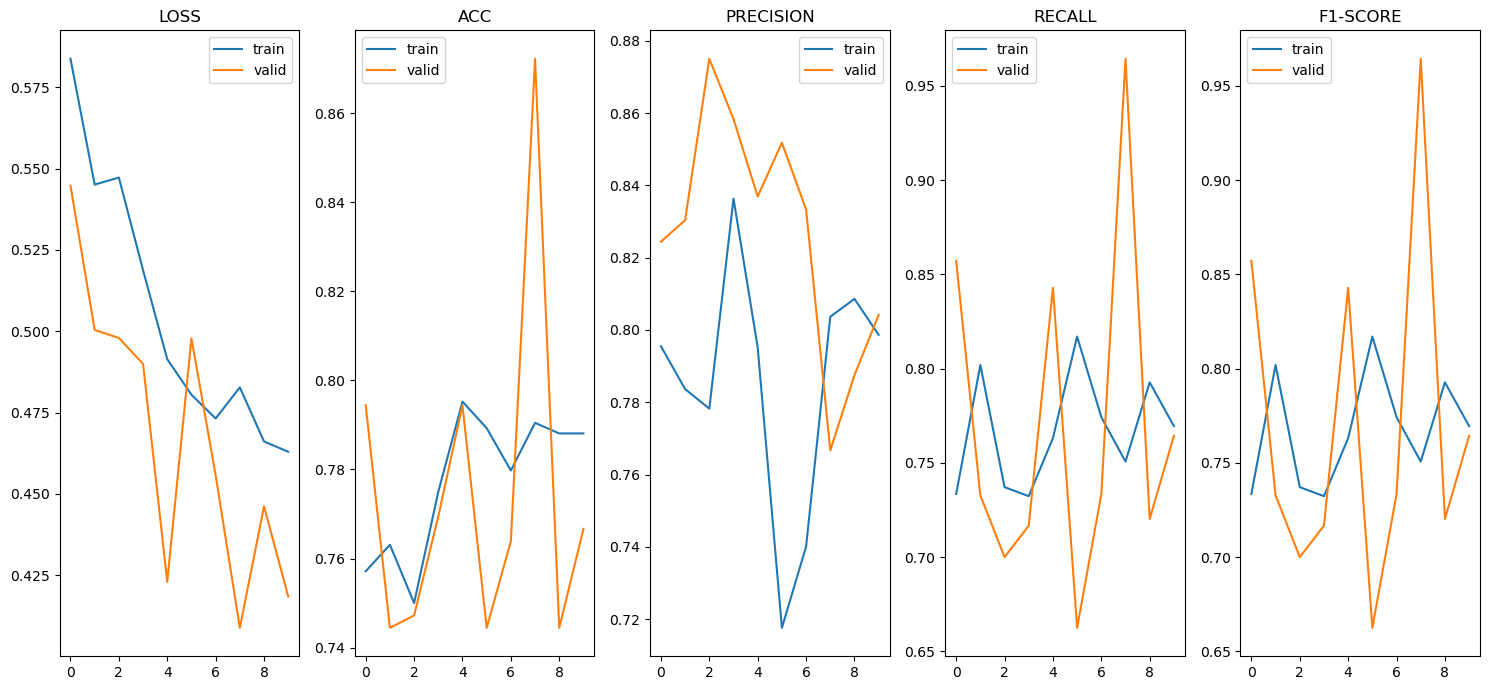

In [610]:
plt.figure(figsize = (15,7))
for k in range(5):
    plt.subplot(1,5,k+1)
    plt.title(title_list[k])
    plt.plot(epo_list, training_list[k], label = 'train')
    plt.plot(epo_list, validing_list[k], label = 'valid')
    plt.legend()
plt.tight_layout()
plt.show()

In [608]:
def predicting(dataloader):
    res_model.eval()
    loss_list = []
    acc_list = []
    precision_list = []
    recall_list = []
    f1score_list = []
    for image, label in dataloader:
        # 학습
        pre_label = res_model(image)
        pre_label = F.sigmoid(pre_label)

        pre_label = pre_label.squeeze()
        # print(label.shape, pre_label.shape)
        # print(label, pre_label, sep = '\n\n')
        
        # 손실계산
        pred_loss = cost(pre_label, label.float())
        # train_loss = cost(pre_label, label)
        
        # 정확도
        acc = metrics.accuracy(pre_label, label, task = 'binary') 
        precision = metrics.precision(pre_label, label, task = 'binary')
        recall = metrics.recall(pre_label, label, task = 'binary')
        f1score = metrics.recall(pre_label, label, task = 'binary')
        loss_list.append(pred_loss)
        acc_list.append(acc)
        precision_list.append(precision)
        recall_list.append(recall)
        f1score_list.append(f1score)
    total_loss = sum(loss_list) / len(loss_list)
    total_acc = sum(acc_list) / len(acc_list)
    total_precision = sum(precision_list) / len(precision_list)
    total_recall = sum(recall_list)/len(recall_list)
    total_f1score = sum(f1score_list) / len(f1score_list)
    print(f"[TOTAL Train Loss] ==> {total_loss}")
    print(f"ACC : {total_acc}  Precision : {total_precision}  Recall : {total_recall} F1score : {total_f1score}")
    return total_loss, total_acc, total_precision, total_recall, total_f1score

# predicting(test_dl)